In [1]:
!pip install tensorflow-ranking==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 4.1 MB/s eta 0:00:00


In [2]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 77.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 76.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempti

In [3]:
import tensorflow_ranking as tfr
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.layers import Input, Dense, Dropout,Flatten
from sklearn.model_selection import train_test_split
from collections import defaultdict
print("TensorFlow version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly

TensorFlow version: 2.9.1


In [4]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

class HammingLoss(Metric):
    def __init__(self, threshold=0.5, name="hamming_loss", **kwargs):
        super(HammingLoss, self).__init__(name=name, **kwargs)
        self.threshold = tf.Variable(threshold, trainable=False, dtype=tf.float32)
        self.hamming_loss = self.add_weight(name="hl", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to binary labels based on threshold
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        # Compute absolute differences
        tmp = tf.math.abs(y_true - y_pred_binary)

        # Compute mean over classes for each sample
        hl = tf.math.reduce_mean(tmp, axis=-1)

        # Update the Hamming loss and sample count
        self.hamming_loss.assign_add(tf.math.reduce_sum(hl))
        self.count.assign_add(tf.cast(tf.size(y_true) / tf.shape(y_true)[-1], tf.float32))

    def result(self):
        return self.hamming_loss / self.count

    def reset_state(self):
        # Reset the Hamming loss and sample count at the end of each epoch
        self.hamming_loss.assign(0.)
        self.count.assign(0.)




In [5]:
data= pd.read_csv('/kaggle/input/models/EfficientNetb4 (1)/test_data.csv')
labels = data.columns[2:-1]

In [6]:
import tensorflow as tf
class CustomImageAugmentation(tf.keras.layers.Layer):
    def __init__(self, flip=True, rotate=True, brightness=True,
                 contrast=True, saturation=True, hue=True, scale=False,
                 crop=False, grid_distortion=False, compression=False,
                 gaussian_noise=False, gaussian_blur=False,
                 downscaling=False, gamma=False, elastic_transform=False, **kwargs):
        super(CustomImageAugmentation, self).__init__(**kwargs)
        self.flip = flip
        self.rotate = rotate
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.scale = scale
        self.crop = crop
        self.grid_distortion = grid_distortion
        self.compression = compression
        self.gaussian_noise = gaussian_noise
        self.gaussian_blur = gaussian_blur
        self.downscaling = downscaling
        self.gamma = gamma
        self.elastic_transform = elastic_transform

    def call(self, inputs, apply=True):
        if apply:
            augmented = tf.image.random_flip_left_right(inputs) if self.flip else inputs
            augmented = tf.image.rot90(augmented, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)) if self.rotate else augmented
            augmented = tf.image.random_brightness(augmented, max_delta=0.2) if self.brightness else augmented
            augmented = tf.image.random_contrast(augmented, lower=0.5, upper=1.5) if self.contrast else augmented
            augmented = tf.image.random_saturation(augmented, lower=0.5, upper=1.5) if self.saturation else augmented
            augmented = tf.image.random_hue(augmented, max_delta=0.2) if self.hue else augmented
            return augmented
        else:
            return inputs
img_aug = CustomImageAugmentation()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=lambda x: img_aug(x, apply=True)
)

In [9]:
target_size=(380, 380)
batch_size=32
test_generatorb4 = datagen.flow_from_dataframe(
    dataframe=data,
    x_col='IMG_DIR',
    y_col=labels,
    class_mode='raw',
    batch_size=batch_size,
    target_size=target_size,
    shuffle=False  # No need to shuffle validation data
)

Found 953 validated image filenames.


In [10]:
from tensorflow.keras.models import load_model
# Load the models with custom names
model1 = load_model('/kaggle/input/models/EfficientNetb4 (1)/EfficientNetB4-Rfid-0.93.h5', custom_objects={'HammingLoss': HammingLoss()})


In [11]:
model1_predictions = model1.predict(test_generatorb4)

30/30 [==============================] - 44s 1s/step


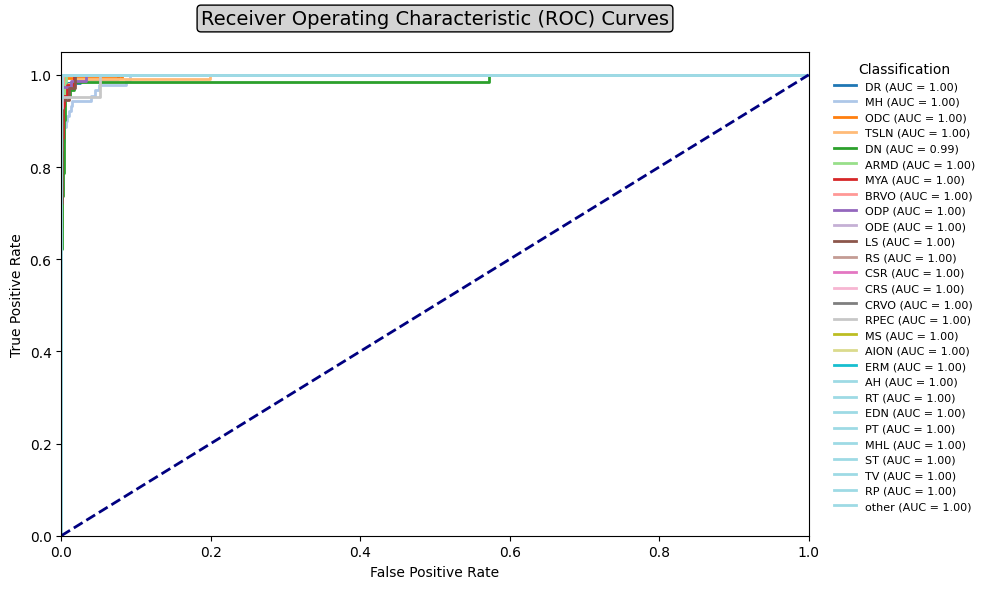

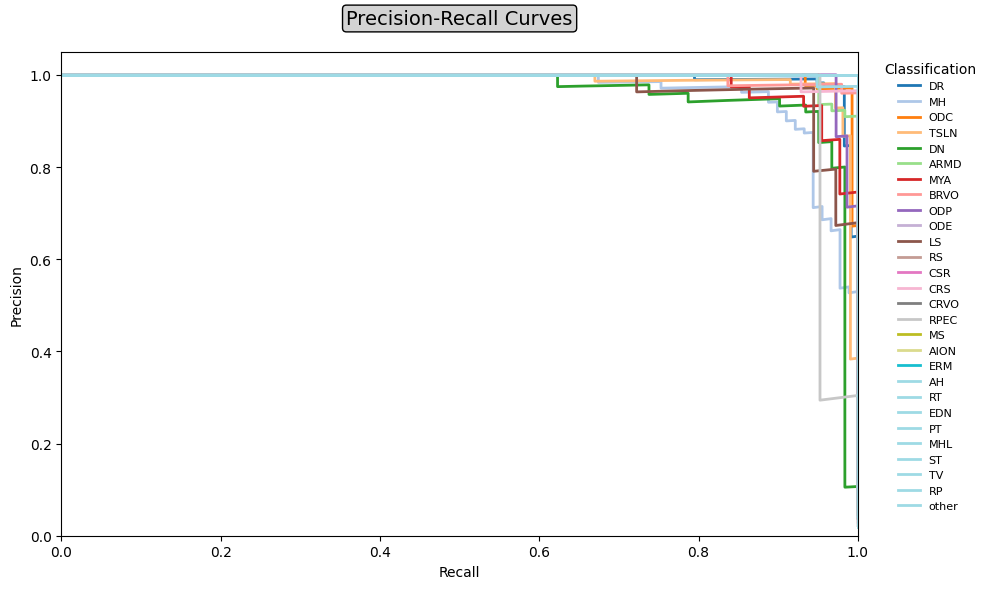

In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate ROC and PR curves for each class

n_classes = len(labels)

fig, ax = plt.subplots(figsize=(10, 6))

# ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_generatorb4.labels[:, i], model1_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  # Set white background for the plot
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

# Precision-recall curve
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(test_generatorb4.labels[:, i], model1_predictions[:, i])
    plt.plot(recall, precision, color=plt.cm.tab20(i), lw=2, label=f'{labels[i]}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, pad=20, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.2'))
plt.legend(title='Classification', loc='upper left', bbox_to_anchor=(1.02, 1), bbox_transform=ax.transAxes, prop={'size': 8}, frameon=False)
plt.gca().set_facecolor('white')  # Set white background for the plot
plt.tight_layout()
plt.show()
